# Topic modelling
In this notebook I will perform topic modelling on the dreddit dataset. I will do this by applying HDBSCAN clustering on the BERT embeddings of the posts. I will use dimensioanilty reduction with UMAP, a method that has proven to work well with HDBSCAN based on this [article](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6).

**Pipeline:**
1) Retrieve text embeddings using the pre-trained DistilBERT<br>
2) Dimensionality reduction with Uniform Manifold Approximation and Projection (UMAP)<br>
3) Perform unsupervised clustering using Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)<br>
4) Topic creation with class based Term Frequency–Inverse Document Frequency (c-TF-IDF)


## Table of contents
* [Getting the data](#Getting-the-data)
* [Main hyperparameters / settings](#Main-hyperparameters-/-settings)
    * [Defining hyperparameters and settings for this run](#Defining-hyperparameters-and-settings-for-this-run)
* [0. Requirements](#0.-Requirements)
* [1. Loading data](#1.-Loading-data)
* [2. Embedding](#2.-Embedding)
    * [2.1 (conditional) Add LIWC features to the embeddings](#2.1-(conditional)-Add-LIWC-features-to-the-embeddings)
* [3. Clustering](#3.-Clustering)
    * [3.1. Dimensionality reduction with UMAP](#3.1.-Dimensionality-reduction-with-UMAP)
    * [3.2. Clustering with HDBSCAN](#3.2.-Clustering-with-HDBSCAN)
    * [3.2. [alternative] Clustering with k-means](#3.2.-[alternative]-Clustering-with-k-means)
    * [3.3. Clusters visualisation](#3.3.-Clusters-visualisation)
* [4. Topic creation](#4.-Topic-creation)
    * [4.1. c-TF-IDF](#4.1.-c-TF-IDF)
    * [4.2. Topic creation](#4.2.-Topic-creation)
* [5. Topic reduction (optional/conditional)](#5.-Topic-reduction-(optional/conditional))
* [6. Understanding the Topics Found](#6.-Understanding-the-Topics-Found)
    * [6.1. Check topic score for each post](#6.1.-Check-topic-score-for-each-post)
    * [6.2. Check topics distribution](#6.2.-Check-topics-distribution)
    * [6.3. Link between subreddit forums and topics created](#6.3.-Link-between-subreddit-forums-and-topics-created)
    * [6.4. [Visualisation] Topics Word Clouds](#6.4.-[Visualisation]-Topics-Word-Clouds)
    * [6.5. Most important words in each topic as a table](#6.5.-Most-important-words-in-each-topic-as-a-table)
    * [6.6. Number of posts in each identified topic (subjectively labelled)](#6.6.-Number-of-posts-in-each-identified-topic-(subjectively-labelled))
        * [6.6.1. Save topics labels as dicitionary for use together with model prediction](#6.6.1.-Save-topics-labels-as-dicitionary-for-use-together-with-model-prediction)
        * [6.6.2. Save model and cluster labels for later predictions with new data](#6.6.2.-Save-model-and-cluster-labels-for-later-predictions-with-new-data)
    * [6.7. Investigating posts in each topic closely](#6.7.-Investigating-posts-in-each-topic-closely)
* [7. Save results](#7.-Save-results)
* [8. Hyperparameters tunning (Grid Search)](#8.-Hyperparameters-tunning-(Grid-Search))
    * [8.1. Get cluster persistence score for each parameter combination](#8.1.-Get-cluster-persistence-score-for-each-parameter-combination)
    * [8.2 Cluster persistence scores vs number of topics](#8.2-Cluster-persistence-scores-vs-number-of-topics)
    * [8.3 Best model with at least n topics / at least x score](#8.3-Best-model-with-at-least-n-topics-/-at-least-x-score)





## Main hyperparameters / settings

- **clustering_method**: choice between HDBSCAN or k-means

#### Data parameters
- **posts_selection**: stressed only, non-stressed only or all; e.g. if 'stressed_only' it will do topic modelling only on posts labelled as stressed; or 'train-split85' will run on subset of the data; else it will run on all pots.
- **use_liwc_output**: if True, it will use the BERT embeddings as well as the LIWC for UMAP+HDBSCAN, otherwise it will use only the BERT embeddings. Note that when using the LIWC output, we use only the first 2780 rows of the train dataset.

#### UMAP parameters 
- **param_n_neighbors**: low values of n_neighbors force UMAP to concentrate on very local structure (potentially to the detriment of the big picture), while large values push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure  for the sake of getting the broader view of the data.
- **param_n_components**: determines the dimensionality of the reduced dimension space we will be embedding the data into.
- **param_seed**: different runs of UMAP can produce slightly different results if no random seed state is set: https://umap-learn.readthedocs.io/en/latest/reproducibility.html

#### HDBSCAN parameters 
- **param_min_cluster_size**: should be set to the smallest size grouping that you wish to consider a cluster.

- **param_min_samples** : The simplest intuition for what min_samples does is provide a measure of how conservative you want you clustering to be. The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas. https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

#### Other parameters
- **param_max_n_topics**: if we get more than this number of topics, we automatically perform topic reduction.

#### Script settings
- **param_redo_embeddings**: if True, it will create the embeddings from BERT from scratch, else it will load embeddings previously created and saved in the 'interim' data subfolder.
- **param_save_figures**: if True, it will saves word clouds figure in the working directory.


## Defining hyperparameters and settings for this run

In [2]:
clustering_method      = 'hdbscan' # 'k-means' or 'hdbscan'

# Data selection
posts_selection        = 'all' # 'stressed_only' , 'non_stressed_only', 'all', 'train-split85'
use_liwc_output        = False  

# UMAP
param_n_neighbors      = 5
param_n_components     = 300
param_seed             = 42

# HDBSCAN
param_min_cluster_size = 10
param_min_samples      = None

# k-means
param_n_clusters       = 20

# Others
param_max_n_topics     = 35

param_redo_embeddings  = False
param_save_figures     = False

## Imports

In [1]:
import copy
import math
import numpy as np
import pandas as pd
import pickle
import os, sys
import hdbscan
import sklearn
import umap.umap_ as umap
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Loading data
Loading Dreddit dataset - train + test


In [2]:
interim_data = os.path.join('..', 'data', 'interim') 
raw_data = os.path.join('..', 'data','raw')
df = pd.concat([pd.read_csv(os.path.join(raw_data, 'dreaddit-train.csv')), 
                           pd.read_csv(os.path.join(raw_data, 'dreaddit-test.csv'))])



In [7]:
df.shape

(3553, 116)

In [3]:
df.head(2)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1.521614e+09,5,1.806818,...,1.000,1.125,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1.527010e+09,4,9.429737,...,1.125,1.000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857


## Sentence embeddings 

I will make use of the BERT deep learning architecure to create sentence embeddings from each post. Using embeddings, it allows for the machine learning models to read and process the data which would be otherwise extremely difficult to manage with categorical data.

**Note**: converting text data to embeddings with this method it takes ~5 min for the whole dataset.

In [24]:
posts = list(df['text'])
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

embeddings_df = pd.DataFrame(model.encode(posts, show_progress_bar=True))
embeddings_df['id'] = df['id'].values
    


In [25]:
embeddings_df.shape

(3553, 769)

In [26]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,id
0,-0.073898,-0.427016,0.879339,-0.886778,-0.424508,-0.495077,0.090677,-0.604774,0.860952,0.580496,...,-0.067804,-0.017727,0.518994,0.334647,-0.403147,-0.054096,0.011078,0.353486,0.034395,33181
1,-0.179551,-0.306599,0.433992,-0.331664,-0.392490,-0.229380,-0.116728,-0.861651,1.048286,-0.114554,...,-0.590860,0.274944,0.470724,0.068690,0.417318,0.029621,0.416718,0.109642,-0.137982,2606
2,-0.118618,-0.143951,0.494451,-0.919306,-0.577948,-0.466200,-0.164303,-0.322160,0.707727,1.267376,...,-0.355498,0.225303,0.017804,0.383267,-0.830719,-0.389978,-0.127854,-0.245244,-0.171759,38816
3,-0.457222,-0.421977,0.427981,-0.604706,-0.454805,-0.451377,-0.028416,-0.213632,0.771071,0.469729,...,-0.478877,0.256927,-0.004667,0.254523,-0.204730,-0.197575,0.035759,-0.296751,-0.214455,239
4,-0.297488,-0.753875,0.580312,-0.682778,-0.627361,-0.051864,-0.326579,-0.845805,0.330753,0.652688,...,0.162422,0.589877,-0.027979,0.169983,-0.744216,-0.255468,-0.198493,0.333754,-0.399182,1421


Beause the run time of the command `model = SentenceTransformer('distilbert-base-nli-mean-tokens')` takes long to complete, we save the embeddings datarame in a csv file in the directory data/interim, so that we can access this faster then next time. 

In [27]:
embeddings_csv = os.path.join(interim_data, 'embeddings.csv')
embeddings_df.to_csv(embeddings_csv)

## Add LIWC features to the embeddings


I will use the LIWC features extarcted previously with the LIWC API and concatenate those features to the embeddings and observe if clustering performs better than when using BERT embeddings alone.


In [22]:
# when using the extracted LIWC features we don't have data for all posts.
# The LIWC API is proprietary and I was able to extract features for about 78% of the total dreaddit posts.

liwc_features_df = pd.read_csv(os.path.join(interim_data, 'LIWC_feature_extraction_dreaddit_data.csv'))
#store the id numbers of the data which have been used in the LIWC analysis
keep_id_list = liwc_features_df['id']
#reduce the embeddings_df dataframe to include only the rows used in LIWC analysis 
embeddings_df = embeddings_df.loc[embeddings_df['id'].isin(keep_id_list)]

# data_df       = keep_relevant_data(data_df, keep_id_list)
# posts_data    = list(data_df['text'])

# # Drop unecessary columns
# liwc_features = liwc_features_temp2.drop(columns=['id', 'post', 'label'])

# # Concatenate embeddings (output from BERT) with LIWC features
# embeddings = pd.concat([embeddings_df, liwc_features], axis=1)

# # Check we have the same data in LWIC, BERT, and posts
# if not(len(embeddings_df)==len(liwc_features)==len(data_df)):
#     print('warning! - check data')
#     sys.exit(0)

In [23]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,id
0,-0.073898,-0.427016,0.879339,-0.886778,-0.424508,-0.495077,0.090677,-0.604774,0.860952,0.580496,...,-0.067804,-0.017727,0.518994,0.334647,-0.403147,-0.054096,0.011078,0.353486,0.034395,33181
1,-0.179551,-0.306599,0.433992,-0.331664,-0.392490,-0.229380,-0.116728,-0.861651,1.048286,-0.114554,...,-0.590860,0.274944,0.470724,0.068690,0.417318,0.029621,0.416718,0.109642,-0.137982,2606


In [7]:
# Drop embeddings posts id
embeddings = embeddings_df.drop(columns='id')

embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.073898,-0.427016,0.879339,-0.886777,-0.424508,-0.495077,0.090677,-0.604774,0.860952,0.580496,...,-0.119797,-0.067804,-0.017727,0.518994,0.334647,-0.403147,-0.054096,0.011077,0.353486,0.034395
1,-0.179551,-0.306599,0.433992,-0.331664,-0.392490,-0.229380,-0.116728,-0.861651,1.048286,-0.114554,...,-0.633758,-0.590860,0.274945,0.470724,0.068690,0.417318,0.029621,0.416718,0.109642,-0.137982
2,-0.118617,-0.143951,0.494451,-0.919306,-0.577948,-0.466200,-0.164303,-0.322160,0.707728,1.267376,...,-0.145725,-0.355497,0.225303,0.017804,0.383267,-0.830719,-0.389978,-0.127854,-0.245244,-0.171759
3,-0.457222,-0.421977,0.427981,-0.604707,-0.454805,-0.451377,-0.028416,-0.213632,0.771071,0.469729,...,0.054773,-0.478877,0.256927,-0.004667,0.254523,-0.204730,-0.197575,0.035759,-0.296751,-0.214455
4,-0.297488,-0.753875,0.580312,-0.682778,-0.627361,-0.051864,-0.326579,-0.845805,0.330754,0.652688,...,0.123428,0.162422,0.589877,-0.027979,0.169983,-0.744216,-0.255467,-0.198493,0.333754,-0.399182


## 3. Clustering
Posts with similar topics should be clustered together, so we use 
clustering to find topics within the clusters formed. 

### 3.1. Dimensionality reduction with UMAP
First, we use UMAP for reducing the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.

**Note:** a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results. Thus, to  optimise topic creation we fine tune the hyperparameters *n_neighbors* and *n_components*.

In [8]:
umap_embeddings_model = umap.UMAP(n_neighbors  = param_n_neighbors, 
                                  n_components = param_n_components, 
                                  random_state = param_seed, # if no random seed is set, results are not reproducible
                                   metric       = 'cosine').fit(embeddings)

umap_embeddings = umap_embeddings_model.embedding_

### 3.2. Clustering with HDBSCAN
After reducing the dimensionality of the posts embeddings to *n_components*, we cluster the documents with HDBSCAN. HDBSCAN does not force data points to clusters as it considers them outliers.

**Note:** if you get an error about 'numpy.ndarray size' see: https://github.com/scikit-learn-contrib/hdbscan/issues/457; reinstalling hdbscan worked for me as it will automatically install the numpy version it needs:  numpy-1.20.2.

In [9]:
if clustering_method == 'hdbscan':
    cluster = hdbscan.HDBSCAN(min_cluster_size         = param_min_cluster_size,
                              min_samples              = param_min_samples,
                              metric                   = 'euclidean',                      
                              cluster_selection_method = 'eom',
                              prediction_data          = True).fit(umap_embeddings)

### 3.2. [alternative] Clustering with k-means
K-means clustering  aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean.
Some important considerations about k-means:
- It tends to not do very well with clusters with no spherical shapes / in which points are not equally distributted around a centroid.
- It forces dapoints into clusters, not allowing for outliers.
- It requires as input the number of clusters intended.

More info on comparing clustering methods: https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

Implementation based on: https://theaidigest.in/how-to-cluster-text-documents-using-bert/

In [10]:
if clustering_method == 'k-means':
    cluster = KMeans(n_clusters=param_n_clusters).fit(umap_embeddings)

### 3.3. Clusters visualisation
To visualize the resulting clusters in a 2-D plot we reduce the dimensionality to 2 and visualize the outliers as grey points.

**Note:** This reduction step is only for visualisation.

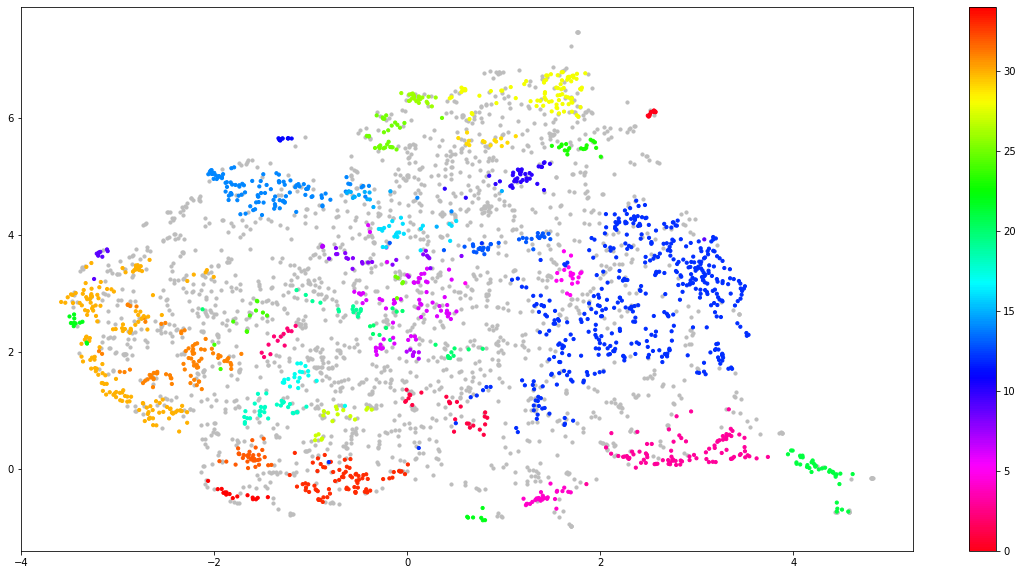

In [11]:
# Dimensionality reduction to 2-D
umap_data = umap.UMAP(n_neighbors  = param_n_neighbors, 
                      n_components = 2, 
                      random_state = param_seed, # if no random seed is set, results are not reproducible
                      min_dist=0.0, metric='cosine').fit_transform(embeddings)

result           = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Plotting
fig, ax   = plt.subplots(figsize=(20, 10))
outliers  = result.loc[result['labels'] == -1, :]
clustered = result.loc[result['labels'] != -1, :]
plt.scatter(outliers['x'], outliers['y'], color='#BDBDBD', s=10)
plt.scatter(clustered['x'], clustered['y'], c=clustered.labels, s=10, cmap='hsv_r')
plt.colorbar()
plt.show()

## 4. Topic creation
Next, we find out what makes potential topics (i.e., clusters of posts) different from one another by looking at the importance of words between those clusters, using a class-based variant of TF-IDF (c-TF-IDF).

TF-IDF, short for term frequency–inverse document frequency, is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

More about TF-IDF and c-TF-IDF: https://www.maartengrootendorst.com/blog/ctfidf/

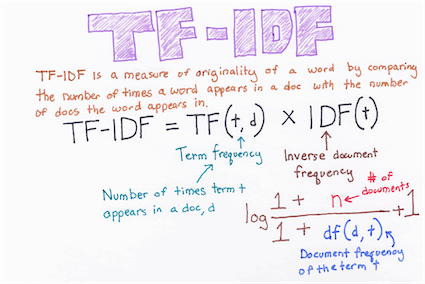

### 4.1. c-TF-IDF
To create this class-based TF-IDF score, we first create a single 
document for each cluster of posts

In [12]:
posts_df            = pd.DataFrame(posts_data, columns=['Post'])
posts_df['Topic']   = cluster.labels_
posts_df['Post_ID'] = data_df['id'].values # add original posts IDs
posts_per_topic     = posts_df.groupby(['Topic'], as_index = False).agg({'Post': ' '.join})

#### Then we apply the class-based TF-IDF
The goal of the class-based TF-IDF is to supply all posts within a single class with the same class vector. In order to do so, we have to start looking at TF-IDF from a class-based point of view instead of individual posts.
If posts are not individuals, but part of a larger collective, then it might be interesting to actually regard them as such by joining all posts in a class together.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    ''' Returns the class-based TF-IDF score for posts/documents. 
    Inputs: 
        * documents    - array of documents/posts per each topic identified;
        * m            - integer, total number of documents/posts, unclustered;
        * n_gram_range - array with the lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted. 
    Outputs:
        * tf_idf      - class-based frequency–inverse document frequency scores;
        * count       - CountVectorizer feature extraction method. '''

    count  = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t      = count.transform(documents).toarray()
    w      = t.sum(axis=1)
    tf     = np.divide(t.T, w)
    sum_t  = t.sum(axis=0)
    idf    = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(posts_per_topic['Post'].values, m=len(posts_data))

### 4.2. Topic creation
Now, we have a single importance value for each word in a cluster which can be used to create the topics.

In [14]:
# Functions for topic creation
def extract_top_n_words_per_topic(tf_idf, count, posts_per_topic, n=20):
    ''' Returns the most relevant words for each topic identified. 
    Inputs: 
        * tf_idf          - class-based frequency–inverse document frequency scores;
        * count           - CountVectorizer feature extraction method;
        * posts_per_topic - array of documents/posts per each topic identified;
        * n               - integer, number of most important words to look at.
    Outputs:
        * top_n_words     - most important words in each identified topic. '''

    words             = count.get_feature_names()
    labels            = list(posts_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices           = tf_idf_transposed.argsort()[:, -n:]
    top_n_words       = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    ''' Returns the size (number of posts/documents) of each topic identified. 
    Inputs: 
        * df          - dataframe with all posts in 'Post' column and topics of each post in 'Topic' column
    Outputs:
        * topic_sizes - number of posts/documents for each topic identified. '''
    
    topic_sizes = (df.groupby(['Topic'])
                     ['Post']
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Post": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

To create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [15]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, posts_per_topic, n=20); 

# Show top n words for an example topic
top_n_words[0] 

[('homeless', 0.1529269899717103),
 ('app', 0.04936909531678512),
 ('food', 0.04832121533342263),
 ('people', 0.044913381860520185),
 ('useful', 0.03482069349940735),
 ('housing', 0.03169844893139546),
 ('street', 0.030461277269470587),
 ('gps', 0.029672684726846615),
 ('choose', 0.029240170260407962),
 ('live', 0.028740310193572198),
 ('crime', 0.026766407240222105),
 ('eligible', 0.026120073152896075),
 ('solution', 0.025560193099963067),
 ('city', 0.024973930670629314),
 ('life', 0.024920027734796915),
 ('possible', 0.02434894655859659),
 ('soon', 0.023551766019985623),
 ('shelters', 0.023524520916391997),
 ('bc', 0.023524520916391997),
 ('relevant', 0.023213795666271565)]

If we take the top n most important words in each cluster, then we get a 
good representation of a cluster, and thereby a topic.

In [16]:
topic_sizes = extract_topic_sizes(posts_df); topic_sizes.head(20) # show top 20 topics
print(str(len(topic_sizes))+' topics') # print number of topics found

36 topics


We can use topic_sizes to view how frequent certain topics are. The topic name -1 refers to all posts that did not have any topics assigned. The great thing about HDBSCAN is that not all documents are forced towards a certain cluster. If no cluster could be found, then it is simply an outlier.

To view the words belonging to those topics, we can simply use the dictionary *top_n_words* to access these topics

## 5. Topic reduction (optional/conditional)
We might get way too many topics, depending on the dataset and hyperparameters used. To reduce the number of topics we can merge the most similar ones by:
- (1) comparing the c-TF-IDF  vectors among topics,
- (2) merge the most similar ones, and 
- (3) re-calculate the c-TD-IDF vectors to  update the topics representation. 

In [17]:
n_topics_before_reduction = len(topic_sizes)-(1 if clustering_method=='hdbscan' else 0) # remove 1 as one of the identified clusters is the one with posts not assigned to any cluster

if n_topics_before_reduction > param_max_n_topics:
        
    for i in range(n_topics_before_reduction - param_max_n_topics): 
        
        # Calculate cosine similarity
        similarities = sklearn.metrics.pairwise.cosine_similarity(tf_idf.T)
        np.fill_diagonal(similarities, 0)
    
        # Extract label to merge into and from where
        topic_sizes         = posts_df.groupby(['Topic']).count().sort_values("Post", ascending=False).reset_index()
        topic_to_merge      = topic_sizes.iloc[-1]['Topic']
        topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1
    
        # Adjust topics
        posts_df.loc[posts_df['Topic'] == topic_to_merge, "Topic"] = topic_to_merge_into
        old_topics        = posts_df.sort_values("Topic")['Topic'].unique()
        map_topics        = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
        posts_df['Topic'] = posts_df.Topic.map(map_topics)
        posts_per_topic   = posts_df.groupby(['Topic'], as_index = False).agg({'Post': ' '.join})
    
        # Calculate new topic words
        m             = len(data_df)
        tf_idf, count = c_tf_idf(posts_per_topic['Post'].values, m)
        top_n_words   = extract_top_n_words_per_topic(tf_idf, count, posts_per_topic, n=20)
    
    topic_sizes = extract_topic_sizes(posts_df); topic_sizes.head(10)

## 6. Understanding the Topics Found

To find out the number of topics we now have, remove 1 as one of the identified clusters is the one with posts not assigned to any cluster.

In [18]:
n_topics = len(topic_sizes)-(1 if clustering_method=='hdbscan' else 0)
print(n_topics)

35


### 6.1. Check topic score for each post

**cluster.probabilities_** : The strength with which each sample is a member of its assigned cluster. Noise points have probability zero; points in clusters have values assigned proportional to the degree that they persist as part of the cluster.
    
**Note**: k-means clustering doesn't produce a probability score.

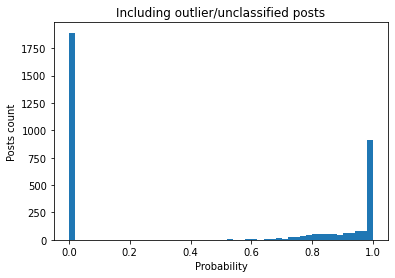

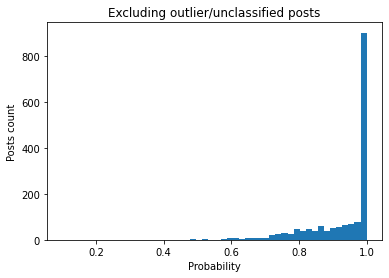

In [19]:
if clustering_method == 'hdbscan':
    posts_df['Probability'] = cluster.probabilities_

    # Probability scores distributions
    plt.hist(posts_df['Probability'], bins=50) # including outliers
    plt.title('Including outlier/unclassified posts')
    plt.ylabel('Posts count')
    plt.xlabel('Probability')
    plt.show()

    plt.hist(posts_df['Probability'], bins=50, range = (0.1,1)) # excluding outliers
    plt.title('Excluding outlier/unclassified posts')
    plt.ylabel('Posts count')
    plt.xlabel('Probability')
    plt.show()

### 6.2. Check topics distribution
Look at number of posts we get in each topic indetified.

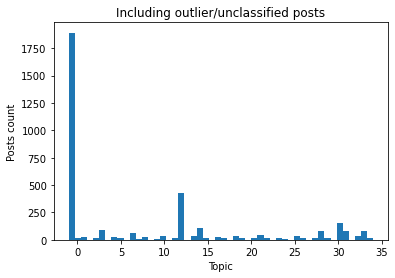

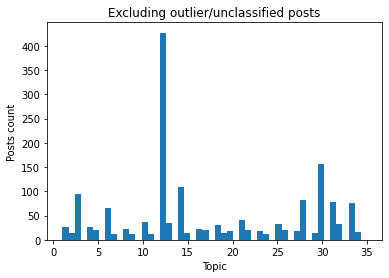

In [20]:
topics_array = posts_df['Topic'].values

plt.hist(topics_array, bins=50) # including outliers
plt.title('Including outlier/unclassified posts')
plt.ylabel('Posts count')
plt.xlabel('Topic')
plt.show()

plt.hist(topics_array, bins=50, range = (1,n_topics)) # excluding outliers
plt.title('Excluding outlier/unclassified posts')
plt.ylabel('Posts count')
plt.xlabel('Topic')
plt.show()

### 6.3. Link between subreddit forums and topics created
Check contribution of each subreddit forum to each topic. In other words, how many posts from each subreddit forum do we have in each topic found to understand whether there is some sort of correlation. For example, do we have more posts from the *assistance* subreddit in the topic that contains words about financial issues?

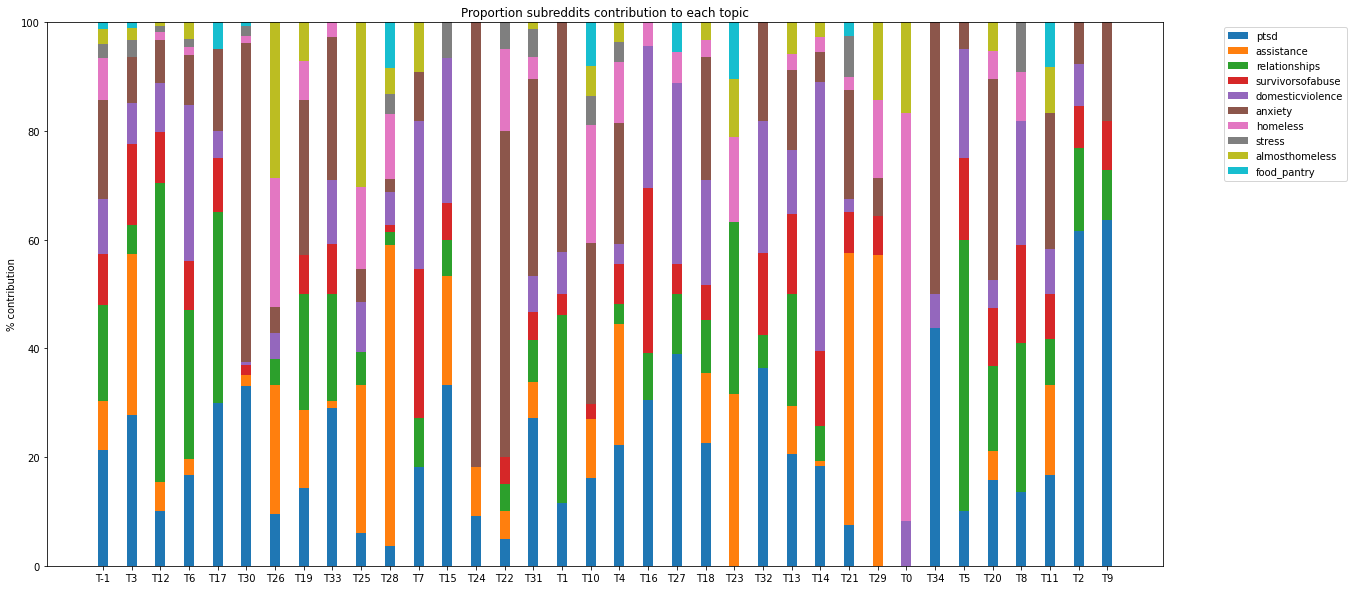

In [21]:
posts_df['subreddit'] = data_df['subreddit'].values

# Getting proportion of posts in each subreddit for each topic
proportions_all_subreddits = []

for subreddit in data_df.subreddit.unique():
    subreddit_proportions = []
    subreddit_posts       = posts_df[posts_df.subreddit==subreddit]
        
    for topic in posts_df['Topic'].unique():
        topic_subreddit_posts = subreddit_posts[subreddit_posts.Topic==topic]
        proportion            = len(topic_subreddit_posts)/len(posts_df[posts_df.Topic==topic])*100
        subreddit_proportions.append(proportion)
        
    proportions_all_subreddits.append(subreddit_proportions)
        
#% Plotting as stacked bar graph
bard_width = 0.35      
labels     = ['T'+str(t) for t in posts_df['Topic'].unique()] # T-1 is no topic assigned
fig, ax    = plt.subplots(figsize=(20,10))

for i, subreddit_name in enumerate(data_df.subreddit.unique()):
    if i>0:
        bottom_values = proportions_all_subreddits[i-1] 
        for i_previous in list(range(i-1)):
            bottom_values = [sum(x) for x in zip(bottom_values, proportions_all_subreddits[i_previous])]
        
    ax.bar(labels, proportions_all_subreddits[i], bard_width, label=subreddit_name, bottom=False if i==0 else bottom_values)
    
ax.set_ylabel('% contribution')
ax.set_title('Proportion subreddits contribution to each topic')
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

### 6.4. [Visualisation] Topics Word Clouds
Visual representation of the most important words in each topic in a cloud of words in which most important words are representade as larger and vice versa.

Based on: https://www.datacamp.com/community/tutorials/wordcloud-python

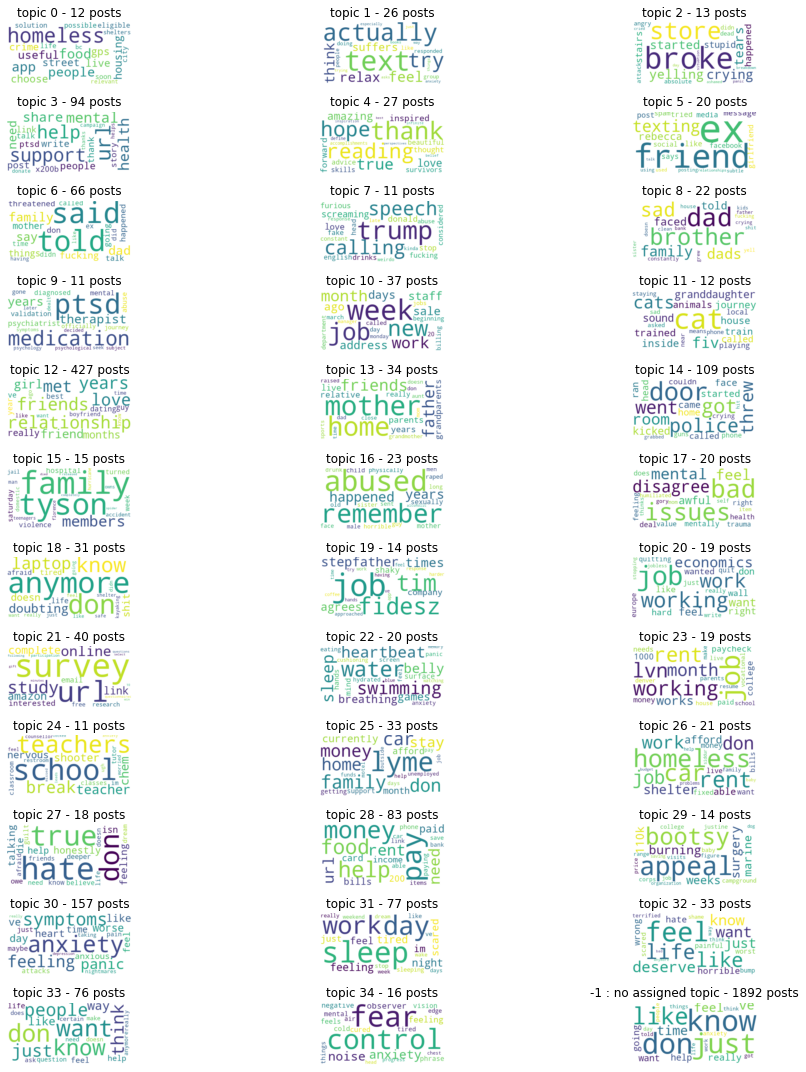

In [22]:
def GetWordsCloud(top_n_words, topic_sizes, save_figure=False):
  ''' Plots a word cloud with the most important words of each topic, scaled for relevance. 
  Inputs: 
   * top_n_words - most important words in each identified topic;
   * topic_sizes - number of posts/documents for each topic identified. '''
    
  fig, axs = plt.subplots(math.ceil(len(top_n_words)/3), 3, figsize = (15,15))
  axes     = axs.ravel()
    
  for i_topic in topic_sizes['Topic']:
    ax = axes[i_topic]
    
    # plot cloud
    cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(dict(top_n_words[i_topic]))
    ax.imshow(cloud, interpolation='bilinear')

    # title shows number of posts per topic
    title_temp = '-1 : no assigned topic' if i_topic==-1 else 'topic '+str(i_topic)
    title      = title_temp + ' - ' + str(topic_sizes[(topic_sizes['Topic']==i_topic)].Size.values.tolist()[0]) + ' posts'
    
    ax.set_title(title)
    
  np.vectorize(lambda ax:ax.axis('off'))(axs)
  plt.tight_layout()
  if save_figure: plt.savefig('word cloud.png',dpi=300)
  plt.show()
  
GetWordsCloud(top_n_words, topic_sizes,save_figure=param_save_figures)

### 6.5. Most important words in each topic as a table
Tabular representation of the most important words in each topic.

In [23]:
display_scores = False # if True will also show score of each word; turn to False to simplify table

# Round up scores to aid visualisation
rounded_top_n_words = copy.deepcopy(top_n_words)
for topic in rounded_top_n_words:
    for word_ix, word in enumerate(rounded_top_n_words[topic]):
        rounded_top_n_words[topic][word_ix] = word[0] + ((' - ' + str(round(word[1],4))) if display_scores else '')

# Display as table        
display(pd.DataFrame(rounded_top_n_words))

,-1,0,1,2,3,4,5,6,7,8,...,25,26,27,28,29,30,31,32,33,34
0,know,homeless,text,broke,url,thank,ex,told,trump,dad,...,lyme,homeless,hate,pay,appeal,anxiety,sleep,feel,don,fear
1,don,app,actually,store,support,reading,friend,said,calling,brother,...,family,car,true,money,bootsy,symptoms,day,life,want,control
2,just,food,try,crying,help,hope,texting,family,speech,sad,...,don,rent,don,help,burning,feeling,work,like,know,anxiety
3,like,people,feel,tears,mental,true,rebecca,dad,screaming,family,...,car,job,honestly,food,surgery,panic,feeling,deserve,people,noise
4,time,useful,think,yelling,health,amazing,message,say,love,dads,...,money,don,talking,rent,weeks,worse,night,want,think,feeling
5,ve,housing,relax,started,share,love,post,fucking,donald,faced,...,home,work,feeling,need,110k,ve,tired,know,just,observer
6,feel,street,suffers,stupid,need,inspired,media,things,furious,told,...,stay,shelter,help,url,marine,day,scared,just,way,cold
7,really,gps,responded,stairs,people,forward,like,mother,stop,constantly,...,currently,afford,isn,paid,campground,like,feel,horrible,like,feels
8,help,choose,like,happened,write,thought,tried,threatened,fake,house,...,afford,able,die,bills,justine,heart,im,hate,help,cured
9,want,live,doing,absolute,post,skills,girlfriend,happened,fucking,yell,...,month,money,deeper,card,corps,time,just,wrong,feel,negative


### 6.6. Number of posts in each identified topic (subjectively labelled)
Check how many posts we have in each of the categories found.

**Important**: This section needs to be manually edited for the topic results of each specific run.

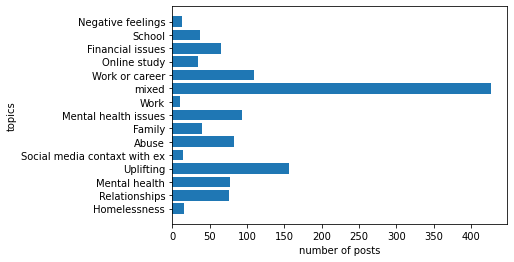

In [24]:
# Subjective, manual labels of each identified topic

if clustering_method=='hdbscan':
    
    if posts_selection=='train-split85':
               topic_labels = ['Homelessness','mixed','Therapy','mixed','Online study','Uplifting','mixed','Relationships','Abuse','Mental health issues','Online study',
                        'Social media contaxt with ex','Abuse','Mental health issues','Relationships','mixed','Abuse','Abuse','Relationships','Abuse','Abuse',
                        'Therapy','School','Family','Abuse','Financial issues','Financial issues','Financial issues','Relationships','Financial issues',
                        'Relationships','Mental health issues','Negative feelings','Relationships','Mental health issues','Family','Financial issues',
                        'Financial issues','Mental health issues','Mental health issues','Mental health issues','Mental heatlth issues','mixed','Mental heatlth issues',
                        'Mental heatlth issues'] 
    else:
        topic_labels = ['Homelessness','Relationships','Relationships','Mental health','Uplifting','Social media contaxt with ex','Abuse',
                        'Relationships','Family','Mental health issues','Work','mixed','Relationships','Family','Abuse','Family','Family','Family',
                        'Mental health issues','mixed','Work or career','Online study','mixed','Financial issues','School','Financial issues',
                        'Financial issues','Abuse','Financial issues','Financial issues','Mental health issues','Mental health issues','Negative feelings',
                        'mixed','Mental health issues']


elif clustering_method=='k-means':
    topic_labels = ['Family','Therapy, anxiety, PTSD, depression','Assistance/help needed','Anxiety, guilt, tired','mixed',
                    'Relationships','Work/job','Family issues','Physical abuse','Therapy, anxiety, PTSD, depression','Work or career',
                    'mixed-cats, pets?','Therapy, anxiety, PTSD, depression','Negative feelings','Income/expenses','Relationships',
                    'Therapy, anxiety, PTSD, depression','Financial issues','Relationships','Uplifting']

topics_posts = [np.sum(np.array(topics_array) == x) for x in range(n_topics)][::-1]

plt.barh(topic_labels,topics_posts)
plt.ylabel('topics')
plt.xlabel('number of posts')
plt.show()

#### 6.6.1. Save topics labels as dicitionary for use together with model prediction

In [25]:
all_topic_labels  = ['unclassified'] + topic_labels
topic_numbers     = list(range(-1 if clustering_method=='hdbscan' else 0, len(topic_labels)))
dict_topic_labels = dict(zip(topic_numbers, all_topic_labels))

dict_file_path    = os.path.join(path_project, 'data','interim', ('unsupervised_clustering_UMAP-HDBSCAN_topics-dictionary' if clustering_method=='hdbscan' else
                                                                  'unsupervised_clustering_UMAP-k-means_topics-dictionary' ))
#pickle.dump(dict_topic_labels,  open(dict_file_path+'.p','wb'))

In [26]:
dict_topic_labels

{-1: 'unclassified',
 0: 'Homelessness',
 1: 'Relationships',
 2: 'Relationships',
 3: 'Mental health',
 4: 'Uplifting',
 5: 'Social media contaxt with ex',
 6: 'Abuse',
 7: 'Relationships',
 8: 'Family',
 9: 'Mental health issues',
 10: 'Work',
 11: 'mixed',
 12: 'Relationships',
 13: 'Family',
 14: 'Abuse',
 15: 'Family',
 16: 'Family',
 17: 'Family',
 18: 'Mental health issues',
 19: 'mixed',
 20: 'Work or career',
 21: 'Online study',
 22: 'mixed',
 23: 'Financial issues',
 24: 'School',
 25: 'Financial issues',
 26: 'Financial issues',
 27: 'Abuse',
 28: 'Financial issues',
 29: 'Financial issues',
 30: 'Mental health issues',
 31: 'Mental health issues',
 32: 'Negative feelings',
 33: 'mixed',
 34: 'Mental health issues'}

#### 6.6.2. Save model and cluster labels for later predictions with new data
Based on: https://github.com/scikit-learn-contrib/hdbscan/issues/172

In [35]:
model_file_path = os.path.join(path_project, 'models', 'unsupervised_clustering_UMAP-'+clustering_method+'_model_'+posts_selection)

# model dictionary to save
model_dict = ({'cluster_method':      clustering_method,
               'cluster_model':       cluster,
               'umap_model':          umap_embeddings_model,
               'topic_labels':        dict_topic_labels,
               'training_data':       posts_selection + '_posts',
               'umap_embeddings':     umap_embeddings,
               'using_LIWC_features': use_liwc_output,
                     
               'parameters': ({'umap_n_neighbors':           param_n_neighbors,
                               'umap_n_components':          param_n_components,
                               'umap_seed':                  param_seed,
                               'max_n_topics':               param_max_n_topics,
                               ('hdbscan_min_cluster_size' if clustering_method=='hdbscan' else 'k_means_n_clusters'): (param_min_cluster_size if clustering_method=='hdbscan' else param_n_clusters) })})

# saving
pickle.dump(model_dict,  open(model_file_path+'.p','wb'))
model_dict

{'cluster_method': 'hdbscan',
 'cluster_model': HDBSCAN(min_cluster_size=10, prediction_data=True),
 'umap_model': UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, metric='cosine',
      n_components=300, n_neighbors=5, random_state=42),
 'topic_labels': {-1: 'unclassified',
  0: 'Homelessness',
  1: 'Relationships',
  2: 'Relationships',
  3: 'Mental health',
  4: 'Uplifting',
  5: 'Social media contaxt with ex',
  6: 'Abuse',
  7: 'Relationships',
  8: 'Family',
  9: 'Mental health issues',
  10: 'Work',
  11: 'mixed',
  12: 'Relationships',
  13: 'Family',
  14: 'Abuse',
  15: 'Family',
  16: 'Family',
  17: 'Family',
  18: 'Mental health issues',
  19: 'mixed',
  20: 'Work or career',
  21: 'Online study',
  22: 'mixed',
  23: 'Financial issues',
  24: 'School',
  25: 'Financial issues',
  26: 'Financial issues',
  27: 'Abuse',
  28: 'Financial issues',
  29: 'Financial issues',
  30: 'Mental health issues',
  31: 'Mental health issues',
  32: 'Negative feelings',
  33:

### 6.7. Investigating posts in each topic closely
Get n most representative posts per topic (posts with highest probability) and read those posts to look more closely at how the topics found cluster together specific types of posts.

In [28]:
n_representative_posts = 3 # number of posts per topic to display

pd.set_option('display.max_colwidth', 0) # so that the post is not cut when displayed (...)

for topic in list(range(n_topics)):
    topic_posts  = posts_df[posts_df.Topic==topic]
    sorted_posts = (topic_posts.sort_values('Probability', axis=0, ascending=False) if clustering_method == 'hdbscan'
                    else topic_posts) # sort only if clustering_method is HDBSCAN
    
    print('Topic '+str(topic))
    display(sorted_posts['Post'].head(n_representative_posts))

Topic 0


217     What if in Ireland a place existed where pollution was zero, crime didn't exist and you where given access to food, warm beds and a chance to rebuild your life. Would you take it? I'm sick of the city, I'm considering a rural life of self sustainability and have adequate means for finding financing to a farm of some sort. Would a homeless scholarship program work for people? Self sustainable life with access to counselling and all food and board paid for help?                                                                                                                                                                                                                                                                                             
882     A lot of very helpful things can be found here, whether it’s how to get benefits and meals, to finding shelter. What I am concerned about is putting together something for the newly homeless in regards to scams, cons, users, people to

Topic 1


69      But she says she can't stand hearing it because she's got enough on her plate as she actually suffers with depression herself. I do read other people's posts and think maybe I've actually had it easy. Maybe I'm just over exaggerating thing, but i feel like I need to get it off my chest. Anyway thanks for reading. ( sorry the post is so long ).                                                                                                                                
1401    I've been thinking about this for weeks and have talked about it with her on numeral occasions and I feel like I'm losing my mind. I just don't know what to feel right now and I'm an emotional wreck. Am I overthinking or it are these reasonable things to worry about?   ---   **tl;dr**: worried what people will say about my girlfriend and I.                                                                                                                                   
3365    Just a simple "seen" status 

Topic 2


743     But I was feeling more and more lonely... like I couldn't trust or rely on her. It was tearing me to pieces and I was always anxious. Finally, after a breakdown I had on christmas over my fears and the lack of help from my partner in healing from this, she broke up with me. I went home the next day and we haven't spoken since. I've been devastated.                                 
765     I started to get depressed but was personally unaware. My wife started to notice that I wasn't eating, was moody, not sleeping, and laying in bed all day. She asked me if I was ok and I... broke down. All emotions came to a tipping point and I started whaling in tears. I told her I had been thinking about suicide.                                                                    
1194    She hobbled down these steps between the living room and kitchen. She didn't ask for help and even when my dad and I both offered she declined. On the way back up the stairs her knee started to hurt or she hi

Topic 3


774     This is a first person group, so you need to be the person with a disorder to participate. To join visit our site <url> or check out our Instagram: <url> We believe we are stronger together, which is why peer support is so helpful and important. Care when you need it; care for others when you can. If you are under 18,  you can find a link to our 13\+ server on the website and instagram. \-Zen                                            
2877    The server encourages happiness and improving yourself. Glamorizing mental illnesses and encouraging people to harm themselves is prohibited. If you are studying something related to mental illnesses or well-being, or if you have a job related to one of those things, you can have a role that shows you are a professional and willing to talk to people in case they have questions or need advice. &#x200B; Invite link: <url>                
855     Hey   everyone! I've just started sharing my story on YouTube, and I intend   to continue buildi

Topic 4


1689    I know it is a huge accomplishment that I've been able to get back on the road and try again. It's just frustrating that I haven't been making as much progress as I'd like. I really miss being independent and free. Does anyone have any tips? I'd love to find someone that can relate or who has overcome this fear.
1823    I need information. As emotional as I am right now, I know I'm not thinking straight and am probably missing something as I research on my own. Any advice, any info, any resource, or organizations that I can apply to to help pay for this is greatly appreciated. I'm in Kansas if that helps... Thank you.          
3136    He loved to learn, he said. I felt his hope. Being free of homelessness is more than just having a roof. I hope he is on the path of thriving, not just surviving. Education is a ladder that nobody can ever take away.                                                                                                 
Name: Post, dtype: object

Topic 5


277     He admitted to using the social media of girls he knows to get off. He even admitted to using his ex's nudes to get off. He downloads that specific app and then usually deletes it. He forgot today. We have sex 1-3 times a day.                                                                                                                                                                                                                   
2791    She never messaged him back, but I asked her why she still had him on Snapchat. I only asked it because she had claimed to have deleted her ex's on social media. Whatever, that's a nice feeling and I'm glad, but at the same time it wouldn't really be an issue for me if she did still have them. Fast forward to last night... My fiance was acting all weird and put out so I tried figure out what was going on and what she was upset about.
675     If she were honest or apologetic, I could try to understand. But is that naive? I’m just confused. I

Topic 6


4       October is Domestic Violence Awareness Month and I am a domestic violence survivor who is still struggling, even after over four years. Lately I have been feeling very angry. Angry that my abusive ex received no real consequences for his actions. This man abused me in all manners: physically, sexually, emotionally, verbally, financially, etc. I was granted a restraining order against him (and it was renewed a year later) but I was unable to press criminal charges against him because I didn’t have enough evidence to have a case.
1460    He said that I should have ptsd because the reason I was wrestling my dad for the gun is because Im a sick bastard who wanted to kill him and the rest of my family. I don't know why I made this post. I don't know if I even really got out what I wanted to say. I just feel so alone. Its been almost a year since that day but even today , my family some how twisted my actions into thinking im some sort of failed murderer                              

Topic 7


38     Sorry this going to be super long, I have a lot to say... Tl;dr... see title. It was constant up and down; one minute we were happy and he was being more affectionate than he has in years, the next he's screaming at me and calling me a whore. I get it, I broke him. I feel so disgusted and ashamed with myself but I truly want to spend my life with no one else.                                                                                                                                                                                                                                                                                             
214    It's late and I should be sleeping but I can't get my husband out of my head, he's just such a freaking weirdo. I feel alone in my situation because most abuse involves some level of anger, but for me my suffering was just his way of showing me affection.  He would always love to wrestle and tickle torture me, and he wouldn't stop when I

Topic 8


302     The worst he's ever done is yell. He does not seek out confrontation and he certainly doesn't threaten people. That's not to say he couldn't hold his own in a fight. My uncle apparently got the message and started crying and begged for forgiveness. My dad told him that he believes he could eventually forgive him, but that doesn't mean he would have anything to do with him.                                                                                                                                                                                                                                                                                                                                                                                                                                    
388     I mean what are you suppose to do when your son is 5 and his older brother who is 16 is picking on him. He was too big for them to punish. So I endured it , some days I hate my whole famil

Topic 9


756     It's been about a year and a half since the event that set my mental health for a loop. After going to group counseling for months with no improvement, I decided to seek out an individual therapist. I didn't get one until a almost year after the event itself. Now, finally, 5 months later, I've been able to see a psychiatrist who officially diagnosed me with generalized anxiety disorder, depression, and PTSD. I decided to get a workbook and my therapist and I are going to start the long journey of getting through my PTSD!
1350    Recently had an ASD evaluation, and was diagnosed instead with PTSD, a personality disorder, major depression, etc. According to my mom, I didn't start talking until I started preschool at 4 years old, and still wouldn't talk at home... but teachers said that I wouldn't stop talking at school. It seems it was my environment. My evaluator recommended I start with EMDR for the PTSD, but I have a few questions. BTW, I am a 40 y/o female just finally trying

Topic 10


2674    I changed jobs last year and moved up into a management role. I run a small program for kids and have 3 staff. Shortly after accepting my position, my job duties completely changed, I hired one new staff person, 2 staff quit and I hired 2 more, and it was up for debate on whether the program would cease to exist by 2019. It feels like I’ve been in survival mode, and everyone was abandoning me...even though I know it wasn’t me they were abandoning. This was rough for me.                                                                                                                      
1092    When you go to bmv/dmv they require a physical as well as mailing address when getting ID or drivers license. For the physical address you can use something descriptive such as "street name " mile marker 3 or under bridge at Dawson/Racine. Where ever you "live". I never knew this until recently and now I try to tell every houseless person I meet just in case. They might look at you weird 

Topic 11


342    Seated on a throne of wire, Mermaids tending to the pyre Golems force the walls to touch As lemurs gaze into the dusk Danny drears while lightning nears                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
549    >This put an end to his trips outside. He has now become a house cat, staying inside. Cats transfer FIV though deep bites from other cats with it, which means at least one of his siblings also has it. Ernie being FIV means that his body is not capable of fighting off diseases. He cannot go outside because if he gets 

Topic 12


3       until i met my new boyfriend, he is amazing, he is kind, he is sweet, he is a good student, he likes the same things as me, my family likes him, and so on... but i dont feel that passion that rush i felt with my ex, the truth is that when i started going out with my boyfriend i secretly saw my ex a few times to see if i really didnt feel nothing for him, but it was disgusting, i didnt even want him to touch me, i feel bad with myself i didnt want him, but still, i was there. then i kinda realized i felt nothing love related for him and it was ok, HE was HURT when he knew i was dating this boy and he even begged me to stay but of course not. but now the problem is that when im with my boyfriend i dont feel like i love him, like that thing you kinda have to feel with a new love, i just feel "ok" with him, and i catch myself thinking about my ex from time to time, remembering all the good things we had and it drives me crazy because i know that if i see him again i wont feel that 

Topic 13


1212    When I grew up, my parents were always working and were never home, didn't express interest in spending time with their children. I was alone all the time and it made me depressed. I wasn't able to make many friends because my parents never drove me to see people. I did parental duties for my siblings. I made my sister meals when she was 7 years old losing weight because my parents never cooked for her.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Topic 14


3533    I remember thinking “What the hell is he doing ?!”. This guy was so tall, so much heavier than me… He grabbed me, was on top of me, told me to “shut my fucking mouth right now”. I tried so hard to move, but I couldn’t… I remember him spitting on his dick, and then he penetrated me, his hand over my mouth. It was so violent, so painful. I can still feel the sweat on his cheek...                                                                                                                                                                                                                                                
1443    They threw me up against the wall, patted me down and told me to sit down outside. The first agent ran in making quick tactical turns around the corners and in the rooms with his gun out. I asked one of the cops what was going on a few times before the words "Child Pornography" dropped out of his mouth like a fucking anvil in my gut. I didn't say anything, I co

Topic 15


281     Quick background: I left this guy back in 2006 after three years, and also turned him in for possession of child pornography and talking to a tween online and getting nudes from her. He plead guilty to Sexual Exploitation of a Minor, avoided federal charges but was put on the sex offender registry in that state. I just found out that he died in March of this year. Stage 4 cancer. It had metastasized by the time they found it, nothing they could do.     
1245    Good Morning, I am extremely moved by the members of this sub contributing to the good of society and answering the call for aid. Last week, footage was released of a mentally challenged man in Germantown, Philadelphia get sucker punched in the head by ruthless teenagers. The victim walked away but still fell victim to another punch. Fortunately the teenagers were arrested and charged.                                                                     
1411    When I was eighteen I lived with my father as adult roomates

Topic 16


3310    When sis "woke up" as a teenager, she started raising hell about the singing evangelist father who'd held her by the wrist, telling her to "watch and learn" while her older sister was forced to copulate him. (Bro was hiding behind the clothes & sliding doors in the closet, watching through the crack.) Spouse had been threatened repeatedly with extinction (from the age of three until she was well-normalized at 13) to "perform." (Grampa got *his* turns, too.) Moreover, the perp beat and otherwise terrorized the mother into submission, and then manipulated her to get out of his way when my two step-daughters were left there by my dissociated spouse.                                                                                                  
1630    He also went to jail when I was in pre school. Last year, my real mom sent me a letter. I had never talked to her. She randomly sent me an easter letter and I saw it and felt weird. I almost started crying but I didnt know why.    

Topic 17


1490    It was worse than that, I wanted to throw up, not because I found the scars disgusting but because the person I loved so so much, had done that to herself. This is when she told me more about her situation, basically all her issues is beacause of a very unstable family with an alcoholic, mentally abusive and neglective father. Her mom is her best friend in the world, but she too suffers from depression and anorexia. Her parents had a terrible divorce where she got caught in the middle, resulting in her falling deeper into depression and self harm tendencies, as well as her mother becoming very anorexic and depressed, all the while her father was drinking. She felt she couldn't burden her mother with her issues and instead keep it to herself, which she does til today as well.
1456    I meant this stuff, and I think I still sort of do. The reason I've been so angry recently is just the general stuff with my family, but also my dad specifically. He's been awful to me in the past c

Topic 18


1371    He denied it and ever since then I think everyone is out to get me and that nothing ever happened and I'm just insane. I always doubt myself and it's hard to hang out with anyone because I think they all have some agenda toward me. I know logically nothing happened but when I get home I have to always check my body for bruises or anything suspicious. Then I feel shameful and want to self harm/die when I realize I'm accusing someone innocent of something so terrible and then my mind tells me nothing ever happened and I'm just nuts. It doesn't help that my family doesn't understand me and minimalizes all of my problems.
1539    Today was a really bad day. I had no energy and I cried and I thought about suicide all day. I'm afraid things will never change for me. I'm not strong enough to change things for myself and I have no help. What can I do?                                                                                                                                         

Topic 19


22     Through work I have been in some dodgy situations abroad. A number of times my life has been at risk, and I've had to defend myself a few times. I'm a civilian and have only had basic weapon training. &#x200B; We've always had an ex-military security contractor with us, but still had to perform aggressive roles when approached.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Topic 20


283     Asked for a little extension. She won’t provide it. I should be able to graduate in December. My academic counselor is looking to help me graduate around some of the program, so I hate to bring my concerns up higher or file with disability. My trauma therapist wants me to advocate higher up.                                                                                                                                                                                                                                                                                                                                                           
427     I'm curious, does anyone know of any programs that provide temporary housing assistance if you have a job? I'm almost broke right now. I really don't want to live out of my car or the shelter while working. Having a comfortable supportive place until I can get my first couple of paychecks would be amazing. I'm worried that my current living s

Topic 21


1496    Hey I was wondering if anyone between the ages of 15-18 (I just find it easier to talk to people around my age, I'm 17) would want to join my Reddit chat group for people who are introverted or suck at socializing like me (don't worry if you just want to listen that's fine too) Some things I like Soccer Tv/movies Music                                                                                    
265     I'm looking for anyone who is interested in taking a 10 minute survey, with the chance to win a £100 (or equivalent) Amazon voucher. You need to be over 18, speak English as a first language, and be able to listen to some audio files and select matching pictures. I've been told it's fun to do! Anyone who enters will be really helping me as I try to progress my research into language and meaning. <url>
446     To help spread the word, I'm also running a competition on social media — prizes: 💸 3 x £50 Amazon vouchers! My instagram is: @thewellnesssocietyorg My twitter is: @t

Topic 22


48      I'm pretty healthy and have a silcock key for water but surviving the heat goes beyond just staying hydrated. Not enough food or the salt that comes with it led to bad cramps most mornings. Sleep was but a wishful dream. When the night time lows are still in the mid 90s, you just sortta sweat and doze. Flip your pillow when its soaking wet and repeat.                                                     
896     You try harder to focus on the screen when another turns on. The screen is large enough that you can clearly make out that it is most definitely a memory. The more you focus, the more screens turn on all showing the same memory. The last screen is so clear, the picture so perfect that it's almost like you are there. As you watch, you realize that you aren't watching anymore- you are in the memory again.
3073    I feel so overwhelmed, I am excited as hell, and twice as much anxious. Any one else experience this before a big dream job or something?? How did you, if you did

Topic 23


3494    I'm a single dad of two daughters (3 and 4). I live in a privately owned apartment with them and the AC went out but is getting fixed tomorrow. I live paycheck to paycheck and can't afford to get a hotel. They are at daycare until 4 when I get off work. I live in Mesa AZ and its been over 100 degrees for weeks.                                                                                                                                                                                                                                                                              
3027    Hi all. I recently moved to another country and it pretty much cost everything to get set up here. My roommate just moved out to start a new chapter with their significant other, taking pretty much all the furniture with them and naturally, rent has gone up. I'm wiped out until the 17th. I, my wife and daughter would appreciate any help to tide us over.                                              

Topic 24


44     I didn't do anything during spring break, except maybe go to work. And even then, I missed a day because I just couldn't deal with the stress. Most adults get excited to tell you they did absolutely nothing during their break. And there was a time when I enjoyed taking a break too. But now it seems like every time I have a break or a day off from work, it makes the stress worse.                                                                                                                                                                                                                                                                                                                           
64     In class, im always on edge, i cant focus on one thing for too long and i constantly scan my environment and I think they think im looking at them which im not. this also made it more awkward to talk to them. I been there for a month but im still very nervous around my peers and teachers.

Topic 25


1441    to complicate things, we live in cities that are hours away from each other and i just wrecked my car. the helplines i keep getting referred to have been useless so far. i'm staying with extended family and have no support relationship-wise from either them or friends because we're all dead broke. i do have a job but i'm having to pay expensive uber fare just to get there as its a while away. i just got the news about this yesterday so i'm frantically searching for answers.
1049    So I'm unemployed, broke, no car or drivers licence (its suspended due to unpaid tickets). Unemployment ran out a month ago and I have no savings. I got a 5 day sheriff lockout two days ago and have until Monday morning to clear out. I pretty much have to leave my stuff behind because I can't afford storage nor can I take it with me on the streets. I'm in the San Fernando valley, Los Angeles County California.                                                                 
2846    Long story short m

Topic 26


3483    I'm living in my car right now which sucks because the radiator just got a hole in it and now I can't keep the AC on at night. I'm working a full time job but I'm not making enough to rent an apartment or even a hotel. What I need is some food. Something portable that won't need refrigeration. I'm former Army so I'm used to MRE's but I don't have anywhere local to get them.                                                                                                                                                                                                                                                                
1931    Basically he makes too much money for help has no other family or friends to help I can barely help myself let alone my dad and his two dogs...but he has literally no where to go and he's gonna be homeless by the time he gets put of his house which he is being evicted from. His credit is too low to get a place and now with this eviction it will be h

Topic 27


97      Even when (now talking about other times) I tried to be playful and like scare prank him, he would beat me up for it. And I still looked up to him for some reason. I believe no child should ever experience these kinds of things. They always drag themselves into your future life. In my case, I have sworn to myself to never become like my father, but I still have these... well, issues.                                                                                                                                                  
1789    In the dream, he kept telling me to do it as he cut himself deeper and deeper in his arm. Then he said I’m gonna do it, all because of you too. You deserve to die, then at the end of the dream he kept holding me down to put a knife against my throat and said this is how it ends, just do it yourself.” I am also looking into talking to someone I can somewhat relate to on this, talking to your friends about this typically doesn’t help me. Thank you f

Topic 28


1108    Rambling about that is over. I would like to save up while doing this over the next couple of months, get my finances back in order, and pay monthly on a land owner finance piece of raw land without covenant restrictions at around $200 a month (that is a possibility in my area, at about 2 acres) and get a tiny building on it or build an earthbag home - somewhere along those lines. The only real concern I have is electricity to do the editing work, but I figure if I do the work I need to do, head to a McDonalds/park/etc to recharge, then I can do alright. I'll be able to store the DJ gear for when its not being used for free. I have a battery charger/car jumper combo I'm keeping in my car I can use for small electronics, and I'm pretty sure I'll have friends who I can see for a couple hours to charge that once a week, and see friends I haven't in years (which obviously is the best part!)
1511    The vet went ahead and removed it but the cost was over $4000. She has a gofundme to

Topic 29


196     I'm posting this one more time for anyone that didn't see it. Our location is in central Louisiana. A co-worker recently gave birth last week and her baby is in stable condition. She was initially told that her baby would have dwarfism and she was okay with that, as long as it was healthy. Later, they told her that her baby wouldn't survive at birth.                                                                                                                                                                                                                                                                                 
471     After the 6 months we moved to a really big house the next town over. It was 3 times the size of the one that burned down. My mom got fired though from nursing because she was caught stealing drugs. My dad graduated college and had a good job in IT and a newspaper place. I don't understand how they could afford such a big house.                            

Topic 30


12      I’ve been taking 12.5 mgs zoloft for about 6 months (yeah, super small dose .. but it was taking the edge off, i think). I decided to stop taking it for a few days to see if it was really helping. Now, about 40 hours since my last dose, I’m suddenly kind of shaky and also flushed (my cheeks are burning for no reason. And THOSE side effects are about to freak me out - do you think it is from my missed dose? Is it possible to have such a fast reaction?                                                                                                                                                                      
2450    *Mindfulness Meditation:* Hopefully you know about this by now:), but there are specific mindfulness meditations that allow you to develop certain parts of your brain. If you want to be happier, there are meditations for that. More concentrated, there are meditations for that. You can choose how to improve yourself and that’s **backed by fucking science. ** Lik

Topic 31


2027    Here comes a little rant, because I don’t know what to do anymore and I’m done with it. I keep on having panic attacks and I can’t find the trigger. I’ve been crying for hours now, and yesterday and the day before as well. I’m seriously afraid that I will go nuts one day, I see no end nor a solution. I’m afraid I’ll end up in a mental hospital.                                                                                                                                                                                                                                                                                                                                            
3059    The news is always problematic for folks with PTSD, but it just feels so much worse lately. I am not one to regularly get triggered by the news, but this weekend just was too much. I just felt like I was swept into this gigantic downward spiral. I really want to go clean up my room and get some food read

Topic 32


2881    But I just can’t do what I need to do because I am terrified that I am doing the “wrong” thing, regardless of what decision I make. But the current situation (doing nothing) is extremely detrimental as well. I feel like a total loser and I am deeply ashamed of this anxiety, though I know that it is nothing to be ashamed of. I’m confident in so many areas of my life, but anxiety targets me and I become immovable. This is one of those times.
3204    I just don't know what's real anymore. I can't live with everyone in my life thinking that I'm crazy AND a hysterical slut. I just can't do this anymore. I'm so ashamed I can't be in this skin anymore. I'm starting to get scared.                                                                                                                                                                                                                      
2605    I feel like I have the worst luck with everything, but maybe that's just bias. I feel li

Topic 33


25      If anything goes wrong, sexually, I want to cease to exist, and a lot of the time, I'm not able to do it out of sheer anxiety. I used to be a very soft person, and I hope I'm still kind, but now I'm quicker to anger, and I don't want to become an abuser. Basically... was I abused? Does that sound like something an abused person would say? I feel like I have the symptoms of PTSD.           
2807    For those that have sought help before, is it as bad as I am imagining? Will I be taken seriously? I feel that because I put myself in that situation, I sort of don't deserve help if that makes sense. I'm not even sure this is the right place to post as I'm not sure it's even a possibility to get some sort of ptsd from something like this. Sorry for the rambling, and thank you for reading.
1525    In my mind I am in control of this, I don’t feel I ‘have’ to try. I can get away. It’s like I’m using drugs to escape but I’m not on drugs I’m just dissociating to a place I want to be. I fe

Topic 34


220    For no reason, I'll just wake up with anxiety like feelings. Stomach ache, uneasiness, some sort of dread, or feeling like any little thing would bring me over the edge and have a panic attack. I don't understand why and it can last for a long time. Anyways. Sometimes the breathing exercises help take the edge off it, but it doesn't fully help.                                                    
364    I’m currently doing EMDR for my severe anxiety issues and depression. We’re going through past instances that have plagued me and are why my mindset is a negative shithole. I had my anxiety in a certain place, where I felt comfortable. The anxiety was there but I managed it well enough. Things were not perfect and there was still a lot of things that needed to change in order for me to progress.
524    In some ways, I can handle it more than the average person who hasn't gone though such a trauma. Sometimes it's hard to remember that, though, when you're breaking down over some ot

## 7. Save results


In [29]:
## Add list of top n words to the topic of each post
n_top_words = 20 # number of words to save with the results
top_n_words = extract_top_n_words_per_topic(tf_idf, count, posts_per_topic, n=n_top_words)

posts_df['Topic_top_'+str(n_top_words)+'_words'] = ''
for post_ix, topic in enumerate(posts_df['Topic']):    
    posts_df.at[post_ix,'Topic_top_'+str(n_top_words)+'_words'] = [x[0] for x in top_n_words[topic]]

## Saving
output_file_path = os.path.join(path_project, 'data','interim', 'unsupervised_clustering_UMAP-'+clustering_method+'_results_'+posts_selection)

# Save as pandas dataframe in pickle format
pickle.dump(posts_df,  open(output_file_path+'.p','wb'))

# Save as CSV file
posts_df.to_csv(output_file_path+'.csv')

## 8. Hyperparameters tunning (Grid Search)
Get score values (cluster.cluster_persistence_) for varying: 
- (1) param_n_neighbors - UMAP
- (2) param_n_components - UMAP 
- (3) param_min_cluster_size - HDBSCAN 

**cluster.cluster_persistence**: A score of how persistent each cluster is. A score of 1.0 represents a perfectly stable cluster that persists over all distance scales, while a score of 0.0 represents a perfectly ephemeral cluster. These scores can be guage the relative coherence of the clusters output by the algorithm.


### 8.1. Get cluster persistence score for each parameter combination
Define search space, i.e., ranges to test - start, limit, step.

In [62]:
range_param_n_neighbors      = range(5,100, 10)
range_param_n_components     = [2, 5, 10, 15, 20, 25, 30, 50, 100, 200, 300]#, 400, 500, 600, 700]
range_param_min_cluster_size = range(10,50, 5)

#### Get cluster persistence score for each parameter combination

In [ ]:
# Initialise grid
persistence_scores = np.zeros([len(range_param_n_neighbors), len(range_param_n_components), len(range_param_min_cluster_size)])
number_topics      = np.zeros([len(range_param_n_neighbors), len(range_param_n_components), len(range_param_min_cluster_size)])

# Fill grid
for ix_1, param_n_neighbors in enumerate(range_param_n_neighbors):
    for ix_2, param_n_components in enumerate(range_param_n_components):
        for ix_3, param_min_cluster_size in enumerate(range_param_min_cluster_size):
            
            # Dimensionality reduction
            umap_embeddings = umap.UMAP(n_neighbors = param_n_neighbors, n_components = param_n_components, 
                                        random_state = param_seed, metric='cosine').fit_transform(embeddings)
            
            # Clustering
            cluster = hdbscan.HDBSCAN(min_cluster_size = param_min_cluster_size, metric = 'euclidean',                      
                                      cluster_selection_method = 'eom').fit(umap_embeddings)
            
            # Using average cluster persistence as persistence score
            persistence_scores[ix_1, ix_2, ix_3] = np.mean(cluster.cluster_persistence_)
            number_topics[ix_1, ix_2, ix_3]    = len(cluster.cluster_persistence_)
            
# Best model & parameters
best_score          = round(np.amax(persistence_scores),3) # best score
position_best_score = np.unravel_index(persistence_scores.argmax(), persistence_scores.shape)
n_topics_best_score = number_topics[position_best_score]

print('Best model: cluster persistence score = ' + str(best_score))
print('N topics: ' + str(n_topics_best_score))
print('Parameters: n_neighbors = {0}; n_components = {1}; min_cluster_size = {2}'.format(range_param_n_neighbors[position_best_score[0]], 
                                                                                         range_param_n_components[position_best_score[1]], 
                                                                                         range_param_min_cluster_size[position_best_score[2]]))

# Save results
tunning_results = ({'cluster_persistence_scores': persistence_scores,
                   'number_topics': number_topics})

file_parameter_tunning = 'unsupervised_clustering_UMAP-HDBSCAN_tunning'

os.chdir(os.path.join(path_project, 'data','interim'))
with open(file_parameter_tunning + '.p', 'wb') as f:
    pickle.dump(tunning_results, f, pickle.HIGHEST_PROTOCOL)

### 8.2 Cluster persistence scores vs number of topics

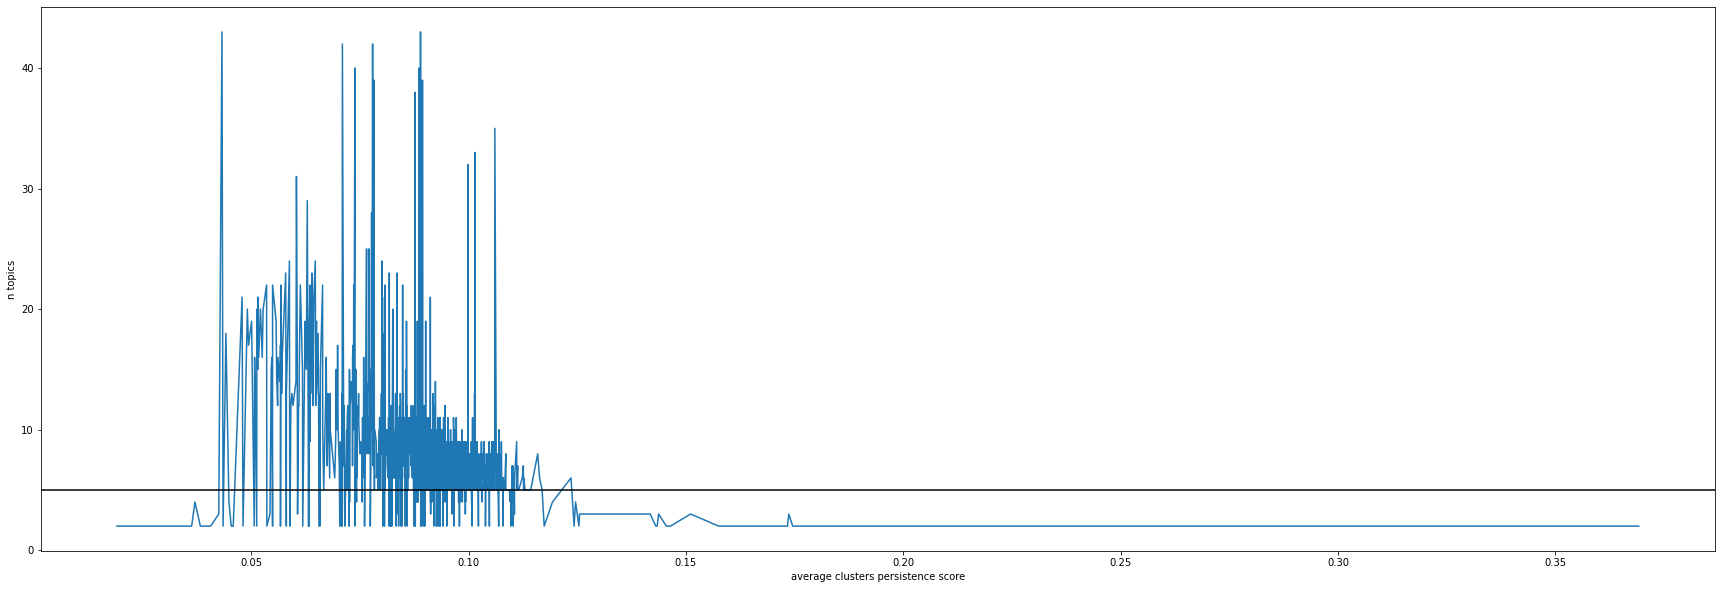

In [31]:
# Load parameters tuning results
def load_parameter_tunning_scores():
    ''' Loads parameter tunning scores from file '''
    file_parameter_tunning = ('unsupervised_clustering_UMAP-HDBSCAN_tunning')

    os.chdir(os.path.join(path_project, 'data','interim'))
    with open(file_parameter_tunning + '.p', 'rb') as f:
        tunning_results =  pickle.load(f)
    return tunning_results

tunning_results = load_parameter_tunning_scores()

# Get scores - n topics values pairs
pairs_df = pd.DataFrame({'scores':list(tunning_results['cluster_persistence_scores'].flatten()),
                         'n_topics': list(tunning_results['number_topics'].flatten())})

sorted_pairs_df = pairs_df.sort_values(by=['scores'])

# Plot
plt.figure(figsize=(30,10))
plt.plot(sorted_pairs_df['scores'], sorted_pairs_df['n_topics'])
plt.ylabel('n topics')
plt.xlabel('average clusters persistence score')
plt.axhline(y = 5, color='k') # show which scores give at least 'y' number of topics
plt.show()

### 8.3 Best model with at least n topics / at least x score

In [63]:
## Based on plot above

# ... define minimum and maximum number of topics intended
minimum_n_topics = 20
maximum_n_topics = 40

# ... define minimum persistence score intended
minimum_persistence_score = 0.10

# Load parameter tuning results
tunning_results = load_parameter_tunning_scores()

# Ignore scores with more or with less topics that we want
thresholded_scores = copy.deepcopy(tunning_results['cluster_persistence_scores'])

thresholded_scores[tuple((np.argwhere(tunning_results['number_topics']<minimum_n_topics)).T)] = 0 # ignore scores with very few topics
thresholded_scores[tuple((np.argwhere(tunning_results['number_topics']>maximum_n_topics)).T)] = 0 # ignore scores with too many topics

# Ignore scores lower than minimum intended
thresholded_scores[tuple((np.argwhere(tunning_results['cluster_persistence_scores']<minimum_persistence_score)).T)] = 0 # ignore scores with very few topics

# Get new score details
best_score          = round(np.amax(thresholded_scores),3) # best score
position_best_score = np.unravel_index(thresholded_scores.argmax(), thresholded_scores.shape)
n_topics_best_score = tunning_results['number_topics'][position_best_score]

# Display them
print('Best model: cluster persistence score = ' + str(best_score))
print('N topics: ' + str(n_topics_best_score))
print('Parameters: n_neighbors = {0}; n_components = {1}; min_cluster_size = {2}'.format(range_param_n_neighbors[position_best_score[0]], 
                                                                                         range_param_n_components[position_best_score[1]], 
                                                                                         range_param_min_cluster_size[position_best_score[2]]))

Best model: cluster persistence score = 0.106
N topics: 35.0
Parameters: n_neighbors = 5; n_components = 300; min_cluster_size = 10
